# Week 12: An Improvement on Boundary Corner
Improving the algorithm implemented last week[[1]](#ref-1)

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - More Examples](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [2]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.util import distance_euclidean
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges, retrieve_boundary_vertices
from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse

# Visualization
import pyvista as pv
from pyvista import examples

from scipy.spatial import Delaunay

C:\Tool\Env\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<a name='1'></a>
## 1 - Test Example

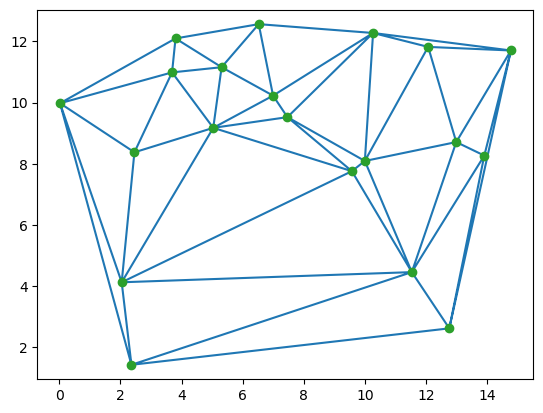

In [3]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=15
points[:, 1]*=15

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

In [4]:
monitor_id=1

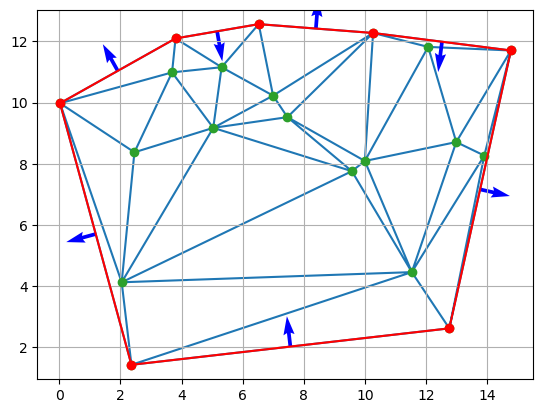

In [5]:
# edges = triangle_edges(tri.simplices)
boundary_vertices = retrieve_boundary_vertices(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)
boundary_angles = retrieve_boundary_angles_2D(boundary_edges, points)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx in boundary_vertices:
    plt.plot(points[idx][0], points[idx][1], 'o', color='red',)
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

# plt.plot(points[monitor_id][0], points[monitor_id][1], 'o', color='black')
plt.axis('equal')
plt.grid() 
plt.show()


In [6]:
faces=tri.simplices.copy()
vertices=points.copy()
boundary_edges = retrieve_boundary_edges(tri.simplices)

In [7]:
lambda1=5
lambda2=5
num_iter = 30

<a name='2'></a>
## 2 - The Loss Function

$$Loss = E^D + \lambda * E^B$$

$E^D$ is the distortion term. A EMIPS energy, which is similar to MIPS energy[[2]](#ref-2), is used.

$$E^D = \sum e^{\frac{s1}{s2}+\frac{s2}{s1}}$$

where $s1$ and $s2$ are the singular values of the Jacobian matrix.

$E^B$ is the alignment term. The algorithm only measure the alignment of boundary edges.

$$E^B = \sum_{i \in b} L_i(||n_i||-1)$$

$\lambda$ is the hyper-parameter to balance the two terms.

In [8]:
def activation(angle):
#     return np.cos(angle) * np.sin(2*angle) / angle
    if angle < (np.pi/2):
        return np.cos(angle) / angle
    else:
        return np.power(np.cos(angle), 2)
        

In [76]:
def energy_designed(x):
    X = x.reshape((v_num, 2))
    
    EB = 0
    for edge in boundary_edges:
        A, B = X[edge[0]], X[edge[1]]
        EB += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)
        
    ED = 0
#     for face in faces:
#         A, B, C = X[face[0]], X[face[1]], X[face[2]]
#         A_, B_, C_ = vertices[face[0]], vertices[face[1]], vertices[face[2]]
        
#         before = np.column_stack([B_-A_,C_-A_])
#         after = np.column_stack([B-A,C-A])
#         J = after @ np.linalg.inv(before)
        
#         u, s, v = np.linalg.svd(J) 
#         s1, s2 = s[0], s[1]
#         ED += np.exp(s1/s2 + s2/s1)
    
    EA = 0
    boundary_angles = retrieve_boundary_angles_2D(boundary_edges, X)
    for angle_value in boundary_angles.values():
#         EA += np.power(np.cos(angle_value), 2)
        EA += activation(angle_value)
        
    return lambda1*EB + lambda2*EA + ED

In [74]:
x0 = np.ravel(vertices)
res_liu = minimize(energy_liu, x0, options = {'maxiter': 20}
#                , method='BFGS'
              )
vertices_liu = res_liu.x.reshape((v_num,2))

In [75]:
x0 = np.ravel(vertices)
res_naive_angle = minimize(energy_naive_angle, x0, options = {'maxiter': 20}
#                , method='BFGS'
              )
vertices_naive_angle = res_naive_angle.x.reshape((v_num,2))

In [76]:
x0 = np.ravel(vertices)
res_designed = minimize(energy_designed, x0, options = {'maxiter': 20}
#                , method='BFGS'
              )
vertices_designed = res_designed.x.reshape((v_num,2))

In [82]:
res_designed

      fun: 26.543386223419905
 hess_inv: array([[ 0.24464271, -0.01961154,  0.        , ...,  0.01210768,
         0.00950953, -0.0116453 ],
       [-0.01961154,  0.3220856 ,  0.        , ...,  0.21324226,
        -0.006765  , -0.01786671],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01210768,  0.21324226,  0.        , ...,  0.27615275,
         0.00718281,  0.0032196 ],
       [ 0.00950953, -0.006765  ,  0.        , ...,  0.00718281,
         0.27226767, -0.00586955],
       [-0.0116453 , -0.01786671,  0.        , ...,  0.0032196 ,
        -0.00586955,  0.26243461]])
      jac: array([ 8.46008682e+00,  7.61935711e-02,  0.00000000e+00,  0.00000000e+00,
       -4.31330676e+01, -5.38335249e+01,  0.00000000e+00,  0.00000000e+00,
        2.84981728e-03,  9.25948429e+00,  8.80223012e+00,  1.73482895e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000

<a name='3'></a>
## 3 - Result

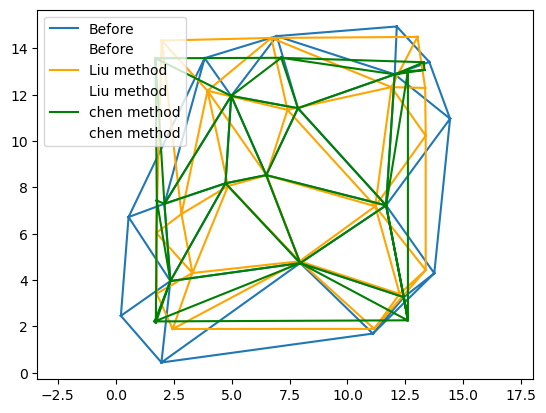

In [81]:
plt.triplot(points[:,0], points[:,1], tri.simplices, label='Before')
plt.triplot(vertices_liu[:,0], vertices_liu[:,1], tri.simplices, color='orange', label='Liu method')
# plt.triplot(vertices_naive_angle[:,0], vertices_naive_angle[:,1], tri.simplices, color='red', label='Angle based')
plt.triplot(vertices_designed[:,0], vertices_designed[:,1], tri.simplices, color='green', label='chen method')
# plt.plot(vertices_liu[:,0], vertices_liu[:,1], 'o')
plt.axis('equal')
plt.legend()
plt.show()

<a name='4'></a>
## 4 - More Examples

In [9]:
new_faces = tri.simplices

In [49]:

edges = retrieve_all_edges(new_faces)
i=-1

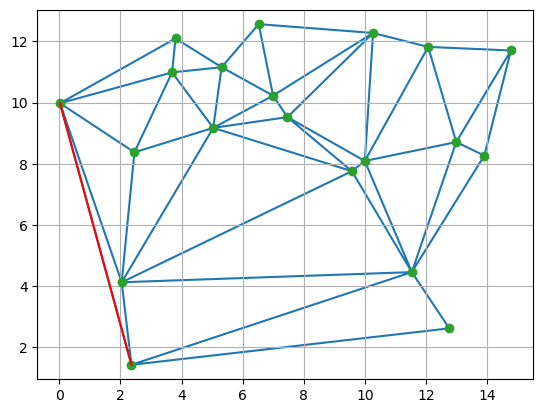

edge:  14
vertices index:  (0, 17)


In [68]:
plt.triplot(points[:,0], points[:,1], new_faces)
plt.plot(points[:,0], points[:,1], 'o')

i+=1
plt.plot(points[np.array(edges[i]), 0], points[np.array(edges[i]), 1], 'r-')
plt.axis('equal')
plt.grid() 
plt.show()
print("edge: ", i)
print("vertices index: ", edges[i])


In [69]:
for idx, face in enumerate(new_faces):
    if  0 in face:
        print(face, idx)

[17  2  0] 0
[ 0 12 11] 2
[ 0  2 12] 3


In [71]:
new_faces = np.delete(new_faces, 0, axis=0)

In [70]:
for idx, face in enumerate(new_faces):
    if 17 in face:
        print(face, idx)

[17  2  0] 0
[17  4  2] 6
[17 19  8] 25
[17  8  4] 26


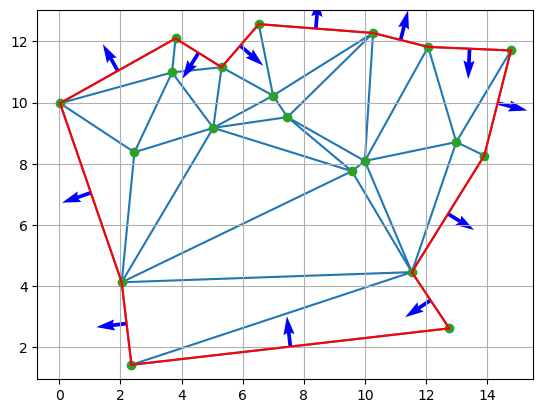

In [72]:
boundary_edges = retrieve_boundary_edges(new_faces)
boundary_angles = retrieve_boundary_angles_2D(boundary_edges, points)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], new_faces)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

plt.axis('equal')
plt.grid() 
plt.show()

In [73]:
faces = new_faces
boundary_edges = retrieve_boundary_edges(new_faces)

In [77]:
x0 = np.ravel(vertices)
res_designed = minimize(energy_designed, x0, options = {'maxiter': num_iter}
#                , method='BFGS'
              )
vertices_designed = res_designed.x.reshape((v_num,2))

In [78]:
res_designed

      fun: 10.066717545421128
 hess_inv: array([[ 3.31221016e-01,  3.10162249e-04,  1.09617287e-03, ...,
         0.00000000e+00, -3.48339436e-03, -6.14486472e-04],
       [ 3.10162249e-04,  5.00293596e-01, -2.91682997e-03, ...,
         0.00000000e+00, -3.08113310e-03,  2.14174491e-03],
       [ 1.09617287e-03, -2.91682997e-03,  3.68789599e-01, ...,
         0.00000000e+00, -1.79403483e-02,  2.82879782e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.48339436e-03, -3.08113310e-03, -1.79403483e-02, ...,
         0.00000000e+00,  3.94098487e-01,  1.75523453e-02],
       [-6.14486472e-04,  2.14174491e-03,  2.82879782e-02, ...,
         0.00000000e+00,  1.75523453e-02,  2.97951292e-01]])
      jac: array([-6.11169624e+00, -5.30885327e+00, -4.99951303e+00,  6.01473129e+00,
        1.11300409e+00, -1.30057335e-04,  5.03702915e+00,  4.99059439e+00,
        0.00000000e+00,  0.00000000e+00, 

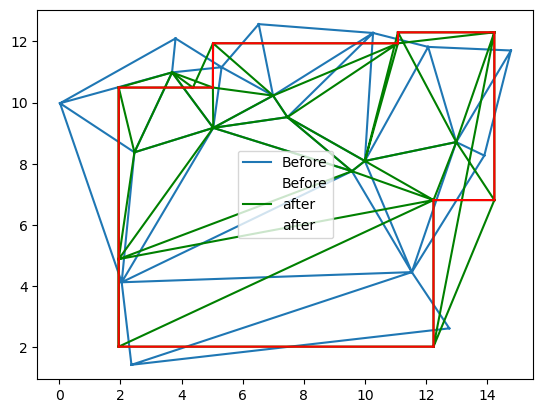

In [86]:
plt.triplot(points[:,0], points[:,1], new_faces, label='Before')
plt.triplot(vertices_designed[:,0], vertices_designed[:,1], tri.simplices, color='green', label='after')
for edge in boundary_edges:
    plt.plot(vertices_designed[np.array(edge), 0], vertices_designed[np.array(edge), 1], 'r-')
# plt.plot(vertices_liu[:,0], vertices_liu[:,1], 'o')
plt.axis('equal')
plt.legend()
plt.show()

Some other non-convex examples

In [317]:
from util.util import v_triangle_2D

In [311]:
# 100 random points
x = np.linspace(-1, 1, v_num)
y = np.power(x, 2) + np.random.uniform(-0.5, 0.5, v_num)
test_points = np.vstack([x,y]).T

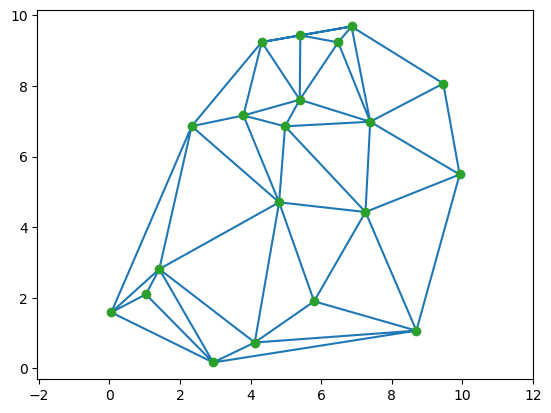

In [663]:
test_points = np.random.rand(v_num, 2)*10
# test_points[:, 0]*=5
# test_points[:, 1]*=2

# Delaunay algorithm to triangulate the mesh
test_tri = Delaunay(test_points)
make_clockwise_2D(points, test_tri.simplices)

plt.triplot(test_points[:,0], test_points[:,1], test_tri.simplices)
plt.plot(test_points[:,0], test_points[:,1], 'o')
plt.axis('equal')
plt.show()

In [764]:
i=-1

triangle index:  6


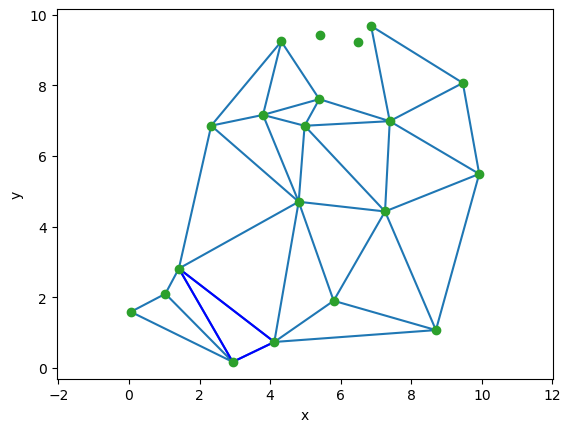

In [771]:
i+=1
A, B, C = test_points[test_tri.simplices[i]]
print("triangle index: ", i)
v_triangle_2D(A,B,C)
plt.triplot(test_points[:,0], test_points[:,1], test_tri.simplices)
plt.plot(test_points[:,0], test_points[:,1], 'o')
plt.axis('equal')
plt.show()



In [763]:
test_tri.simplices = np.delete(test_tri.simplices, 13, axis=0)

In [781]:
faces = test_tri.simplices
boundary_edges = retrieve_boundary_edges(test_tri.simplices)
x0 = np.ravel(test_points)
res = minimize(energy, x0, options = {'maxiter': 20}
#                , method='BFGS'
              )
vertices_opt = res.x.reshape((v_num,2))

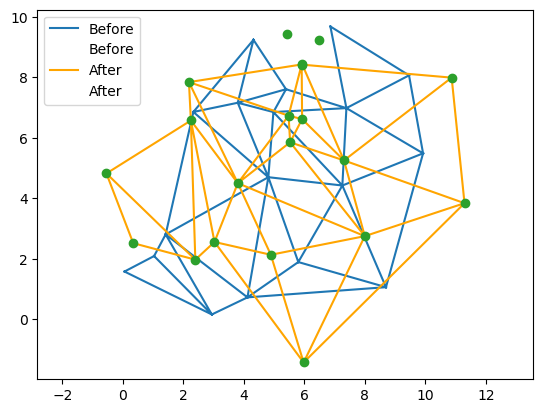

In [782]:
plt.triplot(test_points[:,0], test_points[:,1], test_tri.simplices, label='Before')
plt.triplot(vertices_opt[:,0], vertices_opt[:,1], test_tri.simplices, color='orange', label='After')
plt.plot(vertices_opt[:,0], vertices_opt[:,1], 'o')
plt.axis('equal')
plt.legend()
plt.show()

## 5 - Problems

+ **Flip-over**: As the energy does not contain any methods to prevent **fliping over** (The reference paper adopted a global strategy to subdivide the mesh and preserve features. This algorithm is a local step), it is obvious that when the iteration reach a certain number, the triangle might happen to decay to a line or flip.
+ **Non-convex boundary**: As it is shown above, the method works very well with 2D triangular mesh with convex boundary. But for those with non-convex boundary, it significantly distort
+ **The need of subdivision of single triangle**: The method can not deal with mesh that consists of one triangle. As it is shown on the last example, if there exists cusps in the mesh, the algorithm fail to handle it and may need to subdivide the triangles.

<a name='6'></a>
## 6 - Reference

<a name='ref-1'></a>
1. [Liu C, Yu W, Chen Z, et al. Distributed poly-square mapping for large-scale semi-structured quad mesh generation[J]. Computer-Aided Design, 2017, 90: 5-17.](https://www.sciencedirect.com/science/article/pii/S0010448517300714?casa_token=JiylsQjWSkQAAAAA:RnbFGyT8qf-EsojvYlxX-if7lhZx1TwO8i0XjTwlYa-y1AqIkVAOJHRwOm5VrxhaAUkET4LSkRc)
<a name='ref-2'></a>
1. [Hormann K, Greiner G. MIPS: An efficient global parametrization method[J]. Curve and Surface Design: Saint-Malo 1999, 2000: 153-162.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=02e4f09c9a6d0d770d31c9289d30b7b4e9b5d974)